## En este pruebo una red (emb_size * 4 - 512 - 256 - 128 - 64 - 1) con embeddings de all-MiniLM-L6-v2 - 125 EPOCHS (no vale mucho la pena)

Este primer script usa el modelo de embeddings all-MiniLM-L6-v2 y se pasan esos embeddings a una red neuronal para calcular la similitud entre dos textos.

La red nueronal tiene como entrada los embeddings de los dos textos, concatenados con otro embedding que es la diferencia entre los dos textos y otro que es la multiplicación entre ambos. Luego, la salida es de 1 dimensión, que representa la similitud entre los textos.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_squared_error


In [2]:
# Leer el archivo CSV 
df = pd.read_csv('../plain_text_resume_data.csv')
print("Largo total del dataset:", len(df))
# Shuffle el dataset
df = df.sample(frac=1, random_state=12).reset_index(drop=True)
df_train = df[:int(len(df) * 0.8)]
df_test = df[int(len(df) * 0.8):]
print("Largo del dataset de entrenamiento:", len(df_train))
print("Largo del dataset de prueba:", len(df_test))

Largo total del dataset: 9544
Largo del dataset de entrenamiento: 7635
Largo del dataset de prueba: 1909


In [3]:
# Cargar el modelo pre-entrenado desde Hugging Face

ST_model = SentenceTransformer('all-MiniLM-L6-v2')  # Rápido para similaridad

#model = SentenceTransformer("BAAI/bge-base-en-v1.5")

#from transformers import AutoModel
#model = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5", torch_dtype=torch.float16)


In [4]:
def calculate_embeddings(row, score=True):
    cv_text = row.iloc[0]
    job_description = row.iloc[1]
    # Obtener embeddings
    cv_embedding = ST_model.encode(cv_text, convert_to_tensor=True, normalize_embeddings=True)
    job_embedding = ST_model.encode(job_description, convert_to_tensor=True, normalize_embeddings=True)

    if score:
        # Si se requiere el score real, se asume que está en la tercera columna del DataFrame. Si no, se puede omitir esta parte.
        real_score = row.iloc[2]
        return cv_embedding, job_embedding, real_score
    
    return cv_embedding, job_embedding

In [5]:
embedding_dim = ST_model.get_sentence_embedding_dimension()
print("Dimensión de los embeddings:", embedding_dim)

Dimensión de los embeddings: 384


In [6]:
# Crear el trainset 
trainset = []
for i in tqdm.tqdm(range(len(df_train))):
    row = df_train.iloc[i]
    cv_embedding, job_embedding, real_score = calculate_embeddings(row)
    trainset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))


  0%|          | 0/7635 [00:00<?, ?it/s]/tmp/ipykernel_28818/2597901595.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))
100%|██████████| 7635/7635 [08:10<00:00, 15.57it/s]


In [7]:
# Crear el testset
testset = []
for i in tqdm.tqdm(range(len(df_test))):
    row = df_test.iloc[i]
    cv_embedding, job_embedding, real_score = calculate_embeddings(row)
    testset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))




  0%|          | 0/1909 [00:00<?, ?it/s]/tmp/ipykernel_28818/3142464526.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testset.append((torch.tensor(cv_embedding), torch.tensor(job_embedding), torch.tensor(real_score)))
100%|██████████| 1909/1909 [02:05<00:00, 15.19it/s]


In [10]:
# guardar el trainset
torch.save(trainset, 'trainset_first_nn_2.pt')

# guardar el testset
torch.save(testset, 'testset_first_nn_2.pt')

In [11]:
trainset = torch.load('trainset_first_nn_2.pt')
testset = torch.load('testset_first_nn_2.pt')


In [17]:
class JobMatchingNN(nn.Module):
    def __init__(self, embedding_dim):
        super(JobMatchingNN, self).__init__()
        self.fc1 = nn.Linear(4 * embedding_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()  # para score entre 0 y 1

    def forward(self, emb1, emb2):
        abs_diff = torch.abs(emb1 - emb2) 
        prod = emb1 * emb2
        # la diferencia absoluta y el producto se concatenan para tener más información sobre la relación entre los embeddings
        x = torch.cat([emb1, emb2, abs_diff, prod], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.out(x))
        return x


In [50]:
def graficar_resultados(real_scores, predicted_scores, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(real_scores, predicted_scores, alpha=0.5)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
    plt.xlabel('Score Real')
    plt.ylabel('Score Predicho')
    plt.title(title)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

In [39]:
# Crear el modelo
model = JobMatchingNN(embedding_dim)
# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Definir el número de épocas
num_epochs = 125
# Definir el tamaño del batch
batch_size = 16

# Crear un DataLoader para el conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(trainset[:int(0.85 * len(trainset))], batch_size=batch_size, shuffle=True)
# Crear un DataLoader para el conjunto de validación
val_loader = torch.utils.data.DataLoader(trainset[int(0.85 * len(trainset)):], batch_size=batch_size, shuffle=False)
# Crear un DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


In [40]:
training_losses = []
validation_losses = []

# Entrenar el modelo (separar training y validation)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (emb1, emb2, score) in enumerate(tqdm.tqdm(train_loader)):
        optimizer.zero_grad()
        outputs = model(emb1, emb2)
        loss = criterion(outputs.squeeze(), score.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    training_losses.append(running_loss / len(train_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    # Validación
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for emb1, emb2, score in val_loader:
            outputs = model(emb1, emb2)
            loss = criterion(outputs.squeeze(), score.float())
            val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
    validation_losses.append(val_loss / len(val_loader))


100%|██████████| 406/406 [00:02<00:00, 187.29it/s]


Epoch [1/125], Loss: 0.0189
Validation Loss: 0.0146


100%|██████████| 406/406 [00:02<00:00, 194.60it/s]


Epoch [2/125], Loss: 0.0135
Validation Loss: 0.0128


100%|██████████| 406/406 [00:02<00:00, 179.81it/s]


Epoch [3/125], Loss: 0.0116
Validation Loss: 0.0126


100%|██████████| 406/406 [00:02<00:00, 167.73it/s]


Epoch [4/125], Loss: 0.0104
Validation Loss: 0.0126


100%|██████████| 406/406 [00:02<00:00, 170.03it/s]


Epoch [5/125], Loss: 0.0097
Validation Loss: 0.0110


100%|██████████| 406/406 [00:02<00:00, 142.65it/s]


Epoch [6/125], Loss: 0.0092
Validation Loss: 0.0113


100%|██████████| 406/406 [00:02<00:00, 174.78it/s]


Epoch [7/125], Loss: 0.0087
Validation Loss: 0.0108


100%|██████████| 406/406 [00:02<00:00, 179.27it/s]


Epoch [8/125], Loss: 0.0084
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 161.45it/s]


Epoch [9/125], Loss: 0.0077
Validation Loss: 0.0107


100%|██████████| 406/406 [00:02<00:00, 154.68it/s]


Epoch [10/125], Loss: 0.0075
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 171.96it/s]


Epoch [11/125], Loss: 0.0073
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 168.09it/s]


Epoch [12/125], Loss: 0.0071
Validation Loss: 0.0110


100%|██████████| 406/406 [00:02<00:00, 173.87it/s]


Epoch [13/125], Loss: 0.0066
Validation Loss: 0.0098


100%|██████████| 406/406 [00:02<00:00, 149.65it/s]


Epoch [14/125], Loss: 0.0065
Validation Loss: 0.0101


100%|██████████| 406/406 [00:02<00:00, 163.67it/s]


Epoch [15/125], Loss: 0.0062
Validation Loss: 0.0111


100%|██████████| 406/406 [00:02<00:00, 164.27it/s]


Epoch [16/125], Loss: 0.0059
Validation Loss: 0.0129


100%|██████████| 406/406 [00:02<00:00, 168.16it/s]


Epoch [17/125], Loss: 0.0058
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 161.79it/s]


Epoch [18/125], Loss: 0.0057
Validation Loss: 0.0095


100%|██████████| 406/406 [00:02<00:00, 163.85it/s]


Epoch [19/125], Loss: 0.0054
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 158.63it/s]


Epoch [20/125], Loss: 0.0050
Validation Loss: 0.0096


100%|██████████| 406/406 [00:02<00:00, 161.62it/s]


Epoch [21/125], Loss: 0.0048
Validation Loss: 0.0101


100%|██████████| 406/406 [00:02<00:00, 163.56it/s]


Epoch [22/125], Loss: 0.0047
Validation Loss: 0.0096


100%|██████████| 406/406 [00:02<00:00, 163.86it/s]


Epoch [23/125], Loss: 0.0045
Validation Loss: 0.0099


100%|██████████| 406/406 [00:02<00:00, 157.99it/s]


Epoch [24/125], Loss: 0.0044
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 138.02it/s]


Epoch [25/125], Loss: 0.0042
Validation Loss: 0.0093


100%|██████████| 406/406 [00:02<00:00, 138.30it/s]


Epoch [26/125], Loss: 0.0043
Validation Loss: 0.0092


100%|██████████| 406/406 [00:02<00:00, 136.31it/s]


Epoch [27/125], Loss: 0.0040
Validation Loss: 0.0098


100%|██████████| 406/406 [00:02<00:00, 142.22it/s]


Epoch [28/125], Loss: 0.0037
Validation Loss: 0.0099


100%|██████████| 406/406 [00:03<00:00, 135.29it/s]


Epoch [29/125], Loss: 0.0036
Validation Loss: 0.0112


100%|██████████| 406/406 [00:02<00:00, 147.62it/s]


Epoch [30/125], Loss: 0.0034
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 141.42it/s]


Epoch [31/125], Loss: 0.0032
Validation Loss: 0.0099


100%|██████████| 406/406 [00:02<00:00, 137.81it/s]


Epoch [32/125], Loss: 0.0034
Validation Loss: 0.0104


100%|██████████| 406/406 [00:03<00:00, 133.01it/s]


Epoch [33/125], Loss: 0.0033
Validation Loss: 0.0096


100%|██████████| 406/406 [00:03<00:00, 133.21it/s]


Epoch [34/125], Loss: 0.0030
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 137.32it/s]


Epoch [35/125], Loss: 0.0031
Validation Loss: 0.0096


100%|██████████| 406/406 [00:02<00:00, 138.00it/s]


Epoch [36/125], Loss: 0.0027
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 150.51it/s]


Epoch [37/125], Loss: 0.0026
Validation Loss: 0.0097


100%|██████████| 406/406 [00:03<00:00, 117.89it/s]


Epoch [38/125], Loss: 0.0026
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 136.44it/s]


Epoch [39/125], Loss: 0.0024
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 142.63it/s]


Epoch [40/125], Loss: 0.0023
Validation Loss: 0.0101


100%|██████████| 406/406 [00:02<00:00, 144.09it/s]


Epoch [41/125], Loss: 0.0023
Validation Loss: 0.0098


100%|██████████| 406/406 [00:02<00:00, 142.66it/s]


Epoch [42/125], Loss: 0.0021
Validation Loss: 0.0101


100%|██████████| 406/406 [00:02<00:00, 135.34it/s]


Epoch [43/125], Loss: 0.0021
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 136.68it/s]


Epoch [44/125], Loss: 0.0021
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 136.31it/s]


Epoch [45/125], Loss: 0.0019
Validation Loss: 0.0102


100%|██████████| 406/406 [00:03<00:00, 131.87it/s]


Epoch [46/125], Loss: 0.0020
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 135.60it/s]


Epoch [47/125], Loss: 0.0018
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 135.41it/s]


Epoch [48/125], Loss: 0.0018
Validation Loss: 0.0109


100%|██████████| 406/406 [00:03<00:00, 132.75it/s]


Epoch [49/125], Loss: 0.0017
Validation Loss: 0.0105


100%|██████████| 406/406 [00:03<00:00, 124.91it/s]


Epoch [50/125], Loss: 0.0019
Validation Loss: 0.0114


100%|██████████| 406/406 [00:03<00:00, 126.74it/s]


Epoch [51/125], Loss: 0.0017
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 142.28it/s]


Epoch [52/125], Loss: 0.0013
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 138.74it/s]


Epoch [53/125], Loss: 0.0013
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 151.57it/s]


Epoch [54/125], Loss: 0.0014
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 149.44it/s]


Epoch [55/125], Loss: 0.0015
Validation Loss: 0.0105


100%|██████████| 406/406 [00:03<00:00, 130.63it/s]


Epoch [56/125], Loss: 0.0015
Validation Loss: 0.0108


100%|██████████| 406/406 [00:03<00:00, 123.40it/s]


Epoch [57/125], Loss: 0.0014
Validation Loss: 0.0106


100%|██████████| 406/406 [00:03<00:00, 123.56it/s]


Epoch [58/125], Loss: 0.0012
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 126.56it/s]


Epoch [59/125], Loss: 0.0011
Validation Loss: 0.0108


100%|██████████| 406/406 [00:03<00:00, 129.16it/s]


Epoch [60/125], Loss: 0.0018
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 119.00it/s]


Epoch [61/125], Loss: 0.0011
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 130.97it/s]


Epoch [62/125], Loss: 0.0010
Validation Loss: 0.0106


100%|██████████| 406/406 [00:03<00:00, 130.50it/s]


Epoch [63/125], Loss: 0.0008
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 142.61it/s]


Epoch [64/125], Loss: 0.0019
Validation Loss: 0.0108


100%|██████████| 406/406 [00:02<00:00, 142.05it/s]


Epoch [65/125], Loss: 0.0016
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 141.99it/s]


Epoch [66/125], Loss: 0.0009
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 146.32it/s]


Epoch [67/125], Loss: 0.0007
Validation Loss: 0.0101


100%|██████████| 406/406 [00:02<00:00, 144.18it/s]


Epoch [68/125], Loss: 0.0008
Validation Loss: 0.0107


100%|██████████| 406/406 [00:02<00:00, 139.69it/s]


Epoch [69/125], Loss: 0.0008
Validation Loss: 0.0111


100%|██████████| 406/406 [00:02<00:00, 140.96it/s]


Epoch [70/125], Loss: 0.0008
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 138.59it/s]


Epoch [71/125], Loss: 0.0009
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 148.75it/s]


Epoch [72/125], Loss: 0.0008
Validation Loss: 0.0108


100%|██████████| 406/406 [00:02<00:00, 142.66it/s]


Epoch [73/125], Loss: 0.0009
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 141.99it/s]


Epoch [74/125], Loss: 0.0007
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 144.96it/s]


Epoch [75/125], Loss: 0.0008
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 141.14it/s]


Epoch [76/125], Loss: 0.0009
Validation Loss: 0.0112


100%|██████████| 406/406 [00:02<00:00, 147.81it/s]


Epoch [77/125], Loss: 0.0012
Validation Loss: 0.0122


100%|██████████| 406/406 [00:02<00:00, 147.18it/s]


Epoch [78/125], Loss: 0.0008
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 145.19it/s]


Epoch [79/125], Loss: 0.0005
Validation Loss: 0.0100


100%|██████████| 406/406 [00:02<00:00, 144.14it/s]


Epoch [80/125], Loss: 0.0006
Validation Loss: 0.0113


100%|██████████| 406/406 [00:02<00:00, 137.63it/s]


Epoch [81/125], Loss: 0.0018
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 135.39it/s]


Epoch [82/125], Loss: 0.0007
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 136.28it/s]


Epoch [83/125], Loss: 0.0004
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 129.94it/s]


Epoch [84/125], Loss: 0.0004
Validation Loss: 0.0102


100%|██████████| 406/406 [00:03<00:00, 117.91it/s]


Epoch [85/125], Loss: 0.0005
Validation Loss: 0.0107


100%|██████████| 406/406 [00:02<00:00, 143.16it/s]


Epoch [86/125], Loss: 0.0005
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 144.85it/s]


Epoch [87/125], Loss: 0.0005
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 144.80it/s]


Epoch [88/125], Loss: 0.0007
Validation Loss: 0.0106


100%|██████████| 406/406 [00:03<00:00, 134.87it/s]


Epoch [89/125], Loss: 0.0011
Validation Loss: 0.0113


100%|██████████| 406/406 [00:03<00:00, 132.18it/s]


Epoch [90/125], Loss: 0.0007
Validation Loss: 0.0107


100%|██████████| 406/406 [00:02<00:00, 144.68it/s]


Epoch [91/125], Loss: 0.0004
Validation Loss: 0.0105


100%|██████████| 406/406 [00:02<00:00, 154.34it/s]


Epoch [92/125], Loss: 0.0004
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 149.93it/s]


Epoch [93/125], Loss: 0.0006
Validation Loss: 0.0109


100%|██████████| 406/406 [00:02<00:00, 135.53it/s]


Epoch [94/125], Loss: 0.0011
Validation Loss: 0.0106


100%|██████████| 406/406 [00:02<00:00, 144.96it/s]


Epoch [95/125], Loss: 0.0004
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 137.45it/s]


Epoch [96/125], Loss: 0.0003
Validation Loss: 0.0102


100%|██████████| 406/406 [00:02<00:00, 136.67it/s]


Epoch [97/125], Loss: 0.0003
Validation Loss: 0.0103


100%|██████████| 406/406 [00:02<00:00, 139.69it/s]


Epoch [98/125], Loss: 0.0003
Validation Loss: 0.0107


100%|██████████| 406/406 [00:02<00:00, 144.25it/s]


Epoch [99/125], Loss: 0.0010
Validation Loss: 0.0106


100%|██████████| 406/406 [00:03<00:00, 134.19it/s]


Epoch [100/125], Loss: 0.0009
Validation Loss: 0.0104


100%|██████████| 406/406 [00:02<00:00, 146.30it/s]


Epoch [101/125], Loss: 0.0004
Validation Loss: 0.0103


100%|██████████| 406/406 [00:03<00:00, 113.54it/s]


Epoch [102/125], Loss: 0.0003
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 134.53it/s]


Epoch [103/125], Loss: 0.0002
Validation Loss: 0.0102


100%|██████████| 406/406 [00:03<00:00, 117.00it/s]


Epoch [104/125], Loss: 0.0003
Validation Loss: 0.0104


100%|██████████| 406/406 [00:03<00:00, 127.94it/s]


Epoch [105/125], Loss: 0.0003
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 124.72it/s]


Epoch [106/125], Loss: 0.0005
Validation Loss: 0.0103


100%|██████████| 406/406 [00:03<00:00, 110.55it/s]


Epoch [107/125], Loss: 0.0018
Validation Loss: 0.0111


100%|██████████| 406/406 [00:03<00:00, 115.16it/s]


Epoch [108/125], Loss: 0.0011
Validation Loss: 0.0105


100%|██████████| 406/406 [00:03<00:00, 134.25it/s]


Epoch [109/125], Loss: 0.0003
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 121.20it/s]


Epoch [110/125], Loss: 0.0002
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 116.57it/s]


Epoch [111/125], Loss: 0.0002
Validation Loss: 0.0103


100%|██████████| 406/406 [00:03<00:00, 107.47it/s]


Epoch [112/125], Loss: 0.0002
Validation Loss: 0.0102


100%|██████████| 406/406 [00:03<00:00, 120.28it/s]


Epoch [113/125], Loss: 0.0002
Validation Loss: 0.0105


100%|██████████| 406/406 [00:03<00:00, 124.71it/s]


Epoch [114/125], Loss: 0.0004
Validation Loss: 0.0104


100%|██████████| 406/406 [00:03<00:00, 111.73it/s]


Epoch [115/125], Loss: 0.0005
Validation Loss: 0.0102


100%|██████████| 406/406 [00:03<00:00, 119.19it/s]


Epoch [116/125], Loss: 0.0017
Validation Loss: 0.0117


100%|██████████| 406/406 [00:03<00:00, 112.65it/s]


Epoch [117/125], Loss: 0.0008
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 115.62it/s]


Epoch [118/125], Loss: 0.0002
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 106.64it/s]


Epoch [119/125], Loss: 0.0002
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 123.58it/s]


Epoch [120/125], Loss: 0.0002
Validation Loss: 0.0099


100%|██████████| 406/406 [00:03<00:00, 119.07it/s]


Epoch [121/125], Loss: 0.0001
Validation Loss: 0.0100


100%|██████████| 406/406 [00:03<00:00, 109.42it/s]


Epoch [122/125], Loss: 0.0002
Validation Loss: 0.0101


100%|██████████| 406/406 [00:03<00:00, 114.74it/s]


Epoch [123/125], Loss: 0.0002
Validation Loss: 0.0105


100%|██████████| 406/406 [00:03<00:00, 122.14it/s]


Epoch [124/125], Loss: 0.0013
Validation Loss: 0.0104


100%|██████████| 406/406 [00:03<00:00, 115.38it/s]

Epoch [125/125], Loss: 0.0007
Validation Loss: 0.0098


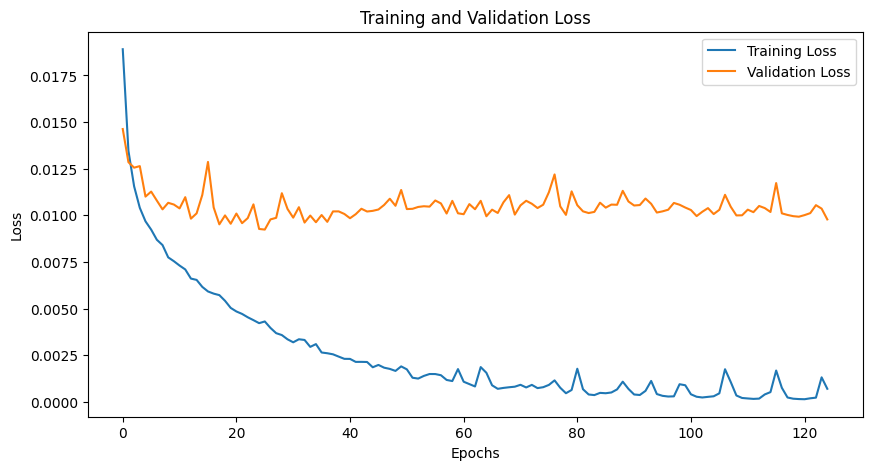

In [41]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

100%|██████████| 1909/1909 [00:00<00:00, 4578.40it/s]


RMSE: 0.0958


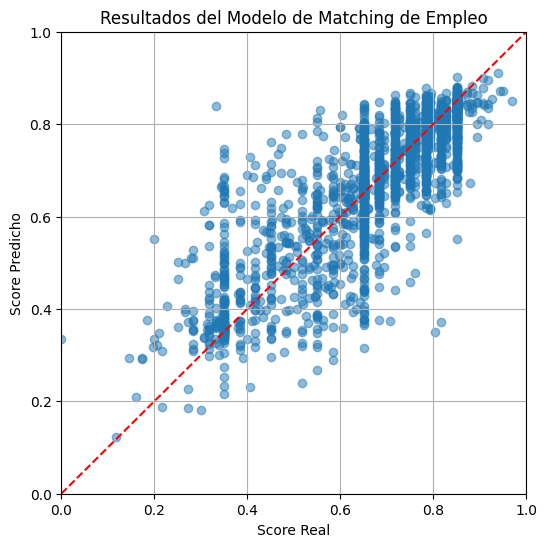

In [51]:
# Evaluar el modelo
model.eval()
predictions = []
real_scores = []
with torch.no_grad():
    for i, (cv_embedding, job_embedding, real_score) in enumerate(tqdm.tqdm(test_loader)):
        outputs = model(cv_embedding.float(), job_embedding.float())
        predictions.extend(outputs)
        real_scores.extend(real_score)
       
# Calcular la precisión
rmse = mean_squared_error(real_scores, predictions) ** 0.5
print(f"RMSE: {rmse:.4f}")
# Graficar los resultados
graficar_resultados(real_scores, predictions, "Resultados del Modelo de Matching de Empleo")

In [49]:
# Evaluar en dos casos particulares

# Buen caso
df_good = pd.read_csv('cv_jd_good_fit.csv')
cv_good_embedding, job_good_embedding = calculate_embeddings(df_good.iloc[0], score=False)
cv_good_embedding = torch.tensor(cv_good_embedding).float().unsqueeze(0)
job_good_embedding = torch.tensor(job_good_embedding).float().unsqueeze(0)
model.eval()
with torch.no_grad():
    good_output = model(cv_good_embedding, job_good_embedding)
    print(f"Predicción para buen caso: {good_output.item():.4f}")

# Mal caso
df_bad = pd.read_csv('cv_jd_bad_fit.csv')
cv_bad_embedding, job_bad_embedding = calculate_embeddings(df_bad.iloc[0], score=False)
cv_bad_embedding = torch.tensor(cv_bad_embedding).float().unsqueeze(0)
job_bad_embedding = torch.tensor(job_bad_embedding).float().unsqueeze(0)
model.eval()
with torch.no_grad():
    bad_output = model(cv_bad_embedding, job_bad_embedding)
    print(f"Predicción para mal caso: {bad_output.item():.4f}")


Predicción para buen caso: 0.7625
Predicción para mal caso: 0.6699


/tmp/ipykernel_28818/3562862592.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cv_good_embedding = torch.tensor(cv_good_embedding).float().unsqueeze(0)
/tmp/ipykernel_28818/3562862592.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  job_good_embedding = torch.tensor(job_good_embedding).float().unsqueeze(0)
/tmp/ipykernel_28818/3562862592.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cv_bad_embedding = torch.tensor(cv_bad_embedding).float().unsqueeze(0)
/tmp/ipykernel_28818/3562862592.py:17: UserWarning: To copy construct fr